<a href="https://colab.research.google.com/github/alessandrodelmonte1/PRA3024_BigDataAnalysis/blob/main/A2_GravitationalWaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1 - Matched Filter 

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 133.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 96.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 142.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
 

In [2]:
#importing packages
import pycbc
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import waveform

from pycbc import frame

from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta
from pycbc.waveform import get_td_waveform
import pycbc.psd


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Part 1: 
- downsample to 2048hz


In [4]:
#Get the GW170817 data
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.frame import read_frame

d = np.load('/content/drive/MyDrive/PRA3024/Week3/GW_noisedata-2.npy') 
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries


#Downsampling
strain, stilde = {}, {}

#Remove low frequency content
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

#Remove beginning and end spikes 
strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

#Create frequency domain version of the data
stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()

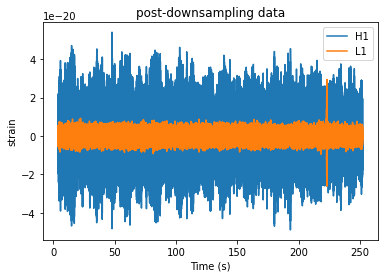

In [5]:
#print plot of strains
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.title('post-downsampling data')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

Part 2 : 
- calculate the matched filter between the given data and a template waveform
- find out the template waveform for which the signal to noise ratio is maximum

0.004032258064516129

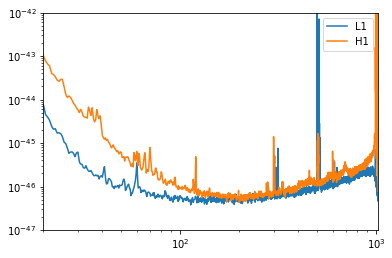

In [6]:
#finding the psds
import pycbc
from pycbc.psd import interpolate 
psds={}

for ifo in ['L1' , 'H1']:
  delta_t = strain[ifo].delta_t
  seg_len = int (2/delta_t)
  seg_stride= int(seg_len/2)
  psds[ifo] =pycbc.psd.welch(strain[ifo],
                             seg_len=seg_len,
                             seg_stride=seg_stride)
  
  psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

  pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
  pylab.xlim(20,1024)
  pylab.ylim(1e-47,1e-42)
pylab.legend()
psds[ifo].delta_f

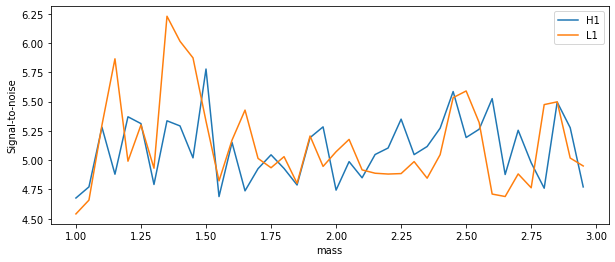

In [7]:
#Finding template waveform for which the signal to noise ratio is maximum

import numpy 
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_eta



masses=numpy.arange(1,3, 0.05)#mass range bewteen 1 to 3 Solar mass and steps of 0.1


#needed variables for when max is found
hmax, smax, tmax, nmax,nsnr= None, {} , {} , 0,0
snrs= {}

#For H1
ifo = 'H1'
Snr_list =[]
for m in masses:
    hp , hc = get_td_waveform(approximant="TaylorT2" , 
                          mass1=m,
                          mass2=m,
                          delta_t=strain[ifo].delta_t,
                          f_lower=20.0)
  
    #resize the vector to match our data 
    hp.resize(len(strain[ifo]))

    #template from generated waveform
    template=hp.cyclic_time_shift(hp.start_time)

    #estimate of signal to noise ratio between data and template
    snr=matched_filter(template, strain[ifo],
                      psd=psds[ifo], low_frequency_cutoff=15.0)
    
    # Crop the data to remove corrupted time by psd and template filter 
    snr_H1 = snr.crop(4 + 4, 4)
    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list


#For L1
ifo = 'L1'
Snr_list= []
for m in masses:
    hp, hc = get_td_waveform(approximant="TaylorT2", 
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=20.0)
    
    #resize the vector to match our data 
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)

    snr= matched_filter (template ,strain[ifo], psd=psds[ifo], low_frequency_cutoff=15.0)
    #Crop the data to remove corrupted time by psd and template filter 
    snr_L1=snr.crop(4+4,4)
    Snr_list.append(max(abs(snr_L1)))
snrs[ifo] = Snr_list

pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label= 'H1')
pylab.plot(masses, snrs['L1'], label= 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()


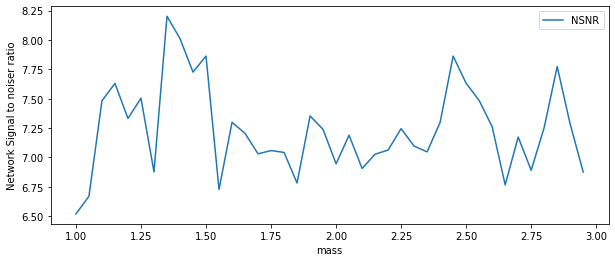

We found the best Mass1=Mass2 was 1.35 solar masses (detector frame)


In [8]:
#getting network snr by combining h1 and l1
from numpy import *
nsnr= sqrt((numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2))
ii= numpy.where (nsnr==max(nsnr))

#plot max snr
pylab.figure(figsize=[10,4])
pylab.plot(masses, nsnr, label='NSNR')
pylab.legend()
pylab.xlabel('mass')
pylab.ylabel('Network Signal to noiser ratio')

pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])


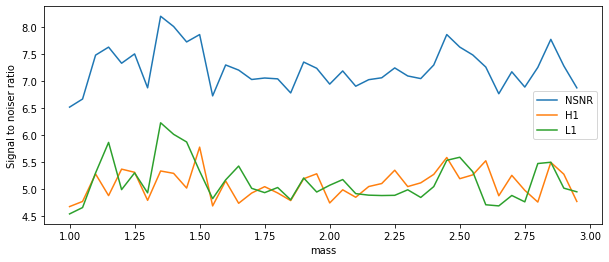

We found the best Mass1=Mass2 was 1.35 solar masses (detector frame)


In [9]:
#plot nsnr with H1 and L1 snr
pylab.figure(figsize=[10,4])
pylab.plot(masses, nsnr , label='NSNR')
pylab.plot(masses, snrs['H1'], label= 'H1')
pylab.plot(masses, snrs['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('mass')
pylab.ylabel('Signal to noiser ratio')

pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])

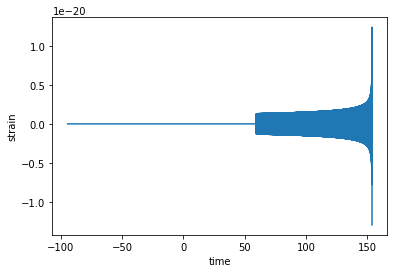

In [10]:
m=1.35 # from previous result

conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=25.0)

# resize the vector to match data
hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times,template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

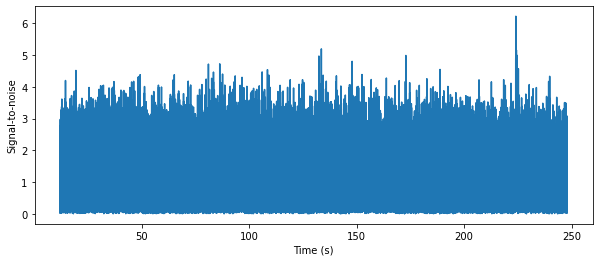

We found a signal at 224.09716796875s with SNR 6.220436611048522


In [11]:
from pycbc.filter import matched_filter
import numpy

for ifo in ['H1' , 'L1']:                     
    conditioned = strain[ifo]
    snr = matched_filter(template, conditioned,
                        psd=psds[ifo] , low_frequency_cutoff=20)
    snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))  #absolute value to get real part of snr
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


In [12]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

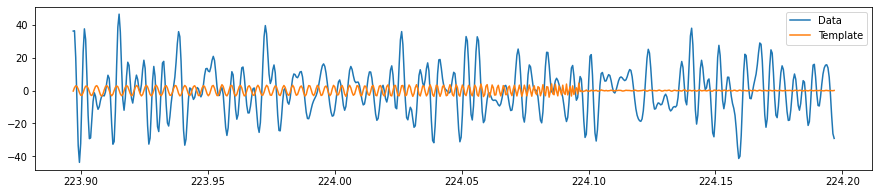

In [13]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-.2, time+.1)
white_template = white_template.time_slice(time-.2, time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

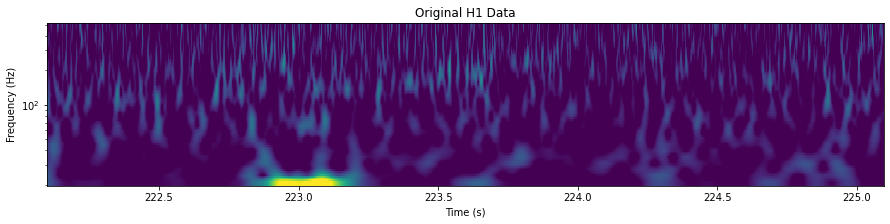

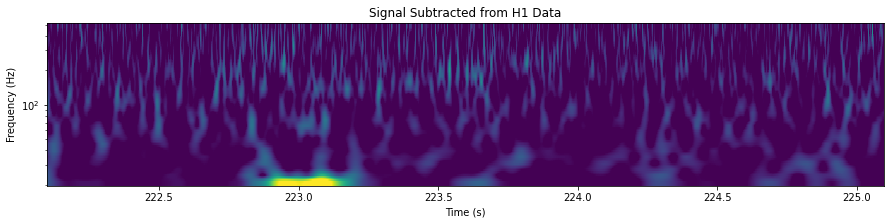

In [14]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(time - 2, time + 1)
    pylab.show()

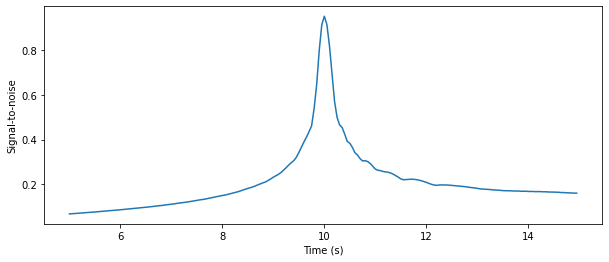

In [15]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match 
from pycbc.psd import aLIGOZeroDetHighPower

f_low= 30
sample_rate=4096
masses = arange(5,15,0.05)
matches = {}

for mass in masses:
  #generate the two waveforms to compare 
  hp, hc = get_td_waveform(approximant = "EOBNRv2", 
                          mass1=10,
                          mass2=10,
                          f_lower = f_low , 
                          delta_t=1.0/sample_rate)
  sp, sc = get_td_waveform(approximant="TaylorT4", 
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  #resize the waveforms to the same length 
  tlen=max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  #generate the aLIGO ZDHP PSD
  delta_f =1.0/sp.duration 
  flen=tlen//2 +1
  psd= aLIGOZeroDetHighPower(flen , delta_f, f_low)

  #

  m,i = match(hp,sp,psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[10, 4])
pylab.plot(*zip(*matches.items()))  
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()


2. Detector noise

In [23]:
#importing packages
import pycbc
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import waveform

from pycbc import frame

from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta
from pycbc.waveform import get_td_waveform
import pycbc.psd


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


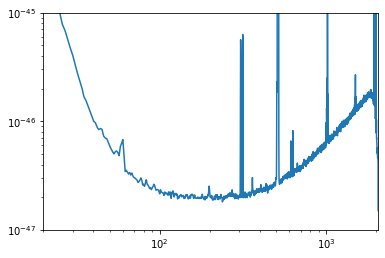

In [29]:
from scipy import interpolate
from pycbc.psd import welch, interpolate
d2=np.load('/content/drive/MyDrive/PRA3024/Week3/a.npy')

dt = d2[:, 0]
d2= pycbc.types.TimeSeries(d2[:, 1], delta_t = dt[1]- dt[0])
data = d2
# Approximating PSDS
psds = interpolate(welch(data), 1.0 / data.duration)
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, max(psds.sample_frequencies))
pylab.ylim(1e-47, 1e-45)
pylab.show()  

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


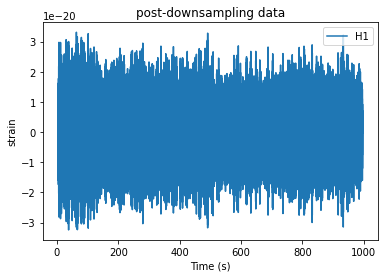

In [30]:
#Downsampling
strain, stilde = {}, {}

#Remove low frequency content
strain = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)

#Remove beginning and end spikes 
strain = strain.crop(4, 4)

#Create frequency domain version of the data
stilde = strain.to_frequencyseries()

#print plot of strain
pylab.plot(strain.sample_times, strain, label= 'H1')
pylab.title('post-downsampling data')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

0.0010080645161290322

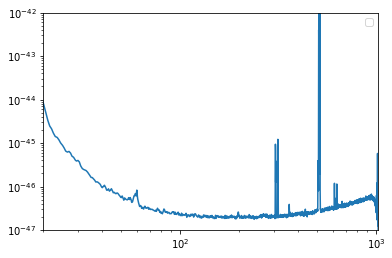

In [31]:
#finding the psds
import pycbc
from pycbc.psd import interpolate 
psds={}


delta_t = strain.delta_t
seg_len = int (2/delta_t)
seg_stride= int(seg_len/2)
psds =pycbc.psd.welch(strain,
                            seg_len=seg_len,
                            seg_stride=seg_stride)

psds = interpolate(psds, stilde.delta_f)

pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20,1024)
pylab.ylim(1e-47,1e-42)
pylab.legend()
psds.delta_f

We did detect a gravitational wave with SNR:[-0.32904129-1.20342115j  0.06362353-1.27099679j  0.54622159-1.18899915j
 ... -2.41955184-0.14557169j -2.17164549-0.55367857j
 -1.86034823-0.85901225j]


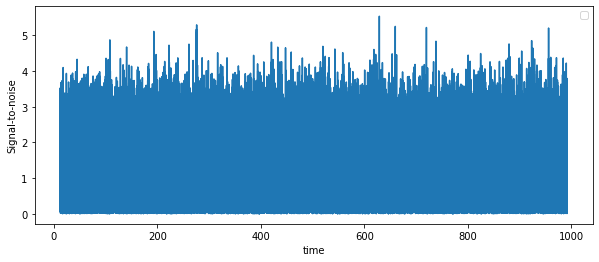

In [33]:

masses = arange(5,10,0.05)
for m in masses:
    hp , hc = get_td_waveform(approximant="TaylorT2" , 
                          mass1=m,
                          mass2=m,
                          delta_t=strain.delta_t,
                          f_lower=20.0)
  
    #resize the vector to match our data 
    hp.resize(len(strain))

    #template from generated waveform
    template=hp.cyclic_time_shift(hp.start_time)

    #estimate of signal to noise ratio between data and template
    snr=matched_filter(template, strain,
                      psd=psds, low_frequency_cutoff=15.0)
    
    # Crop the data to remove corrupted time by psd and template filter 
    snr = snr.crop(4 + 4, 4)
   
#print("We did detect a gravitational wave with SNR:" + str(snr))
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('time')
pylab.show()


SNR is lower than 8. So probably we can assume there is no GW

(array([5.00000e+00, 1.20000e+01, 2.10000e+01, 3.10000e+01, 3.80000e+01,
        4.60000e+01, 8.50000e+01, 1.40000e+02, 1.59000e+02, 2.13000e+02,
        2.78000e+02, 4.17000e+02, 5.44000e+02, 7.22000e+02, 9.15000e+02,
        1.19800e+03, 1.66000e+03, 2.14500e+03, 2.78000e+03, 3.47100e+03,
        4.58900e+03, 5.75800e+03, 7.23400e+03, 8.82900e+03, 1.07770e+04,
        1.30050e+04, 1.60400e+04, 1.90430e+04, 2.30340e+04, 2.67000e+04,
        3.16960e+04, 3.67330e+04, 4.27810e+04, 4.88710e+04, 5.52750e+04,
        6.24050e+04, 6.93080e+04, 7.72070e+04, 8.50710e+04, 9.30980e+04,
        1.00827e+05, 1.08524e+05, 1.16024e+05, 1.22795e+05, 1.28451e+05,
        1.33931e+05, 1.38161e+05, 1.41132e+05, 1.43922e+05, 1.44787e+05,
        1.45306e+05, 1.44467e+05, 1.41631e+05, 1.37538e+05, 1.33937e+05,
        1.28026e+05, 1.22533e+05, 1.16494e+05, 1.08441e+05, 1.01187e+05,
        9.32620e+04, 8.53020e+04, 7.75500e+04, 6.97490e+04, 6.24480e+04,
        5.47840e+04, 4.90020e+04, 4.27500e+04, 3.65

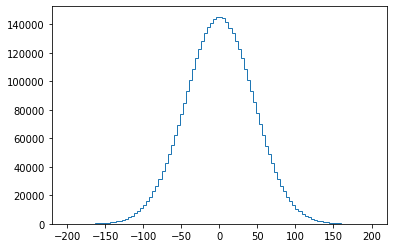

In [38]:
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(data,
                      seg_len=seg_len,
                      seg_stride=seg_stride)
psd = interpolate(welch(data), 1.0 / data.duration)
white_data = (data.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.crop(4,4)


bins = 100
range = (-200.0,200.0)
plt.hist(white_data, histtype='step', range=range , bins = int(bins))